In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.tools.plotting import parallel_coordinates

import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

from scipy import stats
import math

In [2]:
xls = pd.ExcelFile('2014年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2014上半年')
data_lowerHalf = xls.parse('基本信息表2014下半年')
data = pd.DataFrame()
data = pd.concat([data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2015年基本信息表.xls')
data_upperHalf = xls.parse('基本信息表2015年上半年')
data_lowerHalf = xls.parse('基本信息表2015年上半年')
data = pd.concat([data,data_upperHalf,data_lowerHalf],ignore_index=True)

xls = pd.ExcelFile('2016年基本信息表.xls')
data_upperHalf = xls.parse('2016年上半年基本信息表')
data_lowerHalf = xls.parse('2016年下半年基本信息表')
data = pd.concat([data,data_upperHalf,data_lowerHalf],ignore_index=True)
xls.close()

del data_upperHalf
del data_lowerHalf

In [22]:
#删除事故特征，留下道路特征，环境特征；清洗事故类型特征
data.drop(['事故编号','受伤人数','当事人总数','抢救死亡人数Q','机动车数量','死亡人数',
           '直接财产损失','轻伤人数','重伤人数','非机动车数量','行人数量','路名','事故形态',\
           '单车事故','是否简易程序','路外事故类型','车辆间事故.1','逃逸事故侦破','事故认定原因',\
           '事故认定原因分类小类'],axis=1,inplace=True)
data.drop(['事故初查原因','事故初查原因分类','失踪人数','文书状态',\
           '是否逃逸','调解人1','调解人2','车辆间事故','运载危险品事故后果'],axis=1,inplace=True)
data.drop(['公安部事故编号','所属中队'],axis=1,inplace=True)
data = data[data.事故类型.isin(['简易程序事故','伤人事故','死亡事故','财产损失事故'])]
data.drop(['现场'],axis=1,inplace=True)
data.drop(['米数'],axis=1,inplace=True)
data.drop(['损坏机动车数','损坏非机动车数'],axis=1,inplace=True)
data.drop(['涉外事故'],axis=1,inplace=True)

In [25]:
#将事故发生时间化解为是否节假日，是否白天
isHolidayFrom140101To161231 = pd.read_excel('isHolidayFrom140101To161231_17.10.23_re.xlsx')
date = pd.DataFrame(data['事故发生时间'])
date = pd.to_datetime(date['事故发生时间'])

def getAccidentDayWithoutHour(i):
    day = str(i.day)
    month = str(i.month)
    if i.day<10:
        day = '0'+day
    if i.month<10:
        month = '0'+month
    theDate = str(i.year)+month+day
    return theDate

accidentDayWithoutHour = pd.DataFrame(date.apply(getAccidentDayWithoutHour))
isHolidays = list()
for i in accidentDayWithoutHour['事故发生时间']:
    isH = isHolidayFrom140101To161231[isHolidayFrom140101To161231.date_day==int(i)]['isHoliday'].iloc[0]
    isHolidays.append(isH)
    
isHolidays = pd.DataFrame(isHolidays)
isHolidays['index'] = range(len(isHolidays))
isHolidays = isHolidays.set_index(['index'])
data.insert(loc=1,column='是否节假日',value=isHolidays)#0为工作日，1为周末，2为节假日

del isHolidayFrom140101To161231,accidentDayWithoutHour,isHolidays,isH

#添加是否白天属性
#白天或夜晚
isDayorNight = list()
for i in date:
    if i.hour>=19 or i.hour<7:
        isDayorNight.append('夜晚')
    else:
        isDayorNight.append('白天')
isDayorNight = pd.Series(isDayorNight)

data.insert(2,'是否白天',isDayorNight)

del isDayorNight,date
data.drop(['事故发生时间'],axis=1,inplace=True)

In [28]:
data.to_excel('data_accidentForPapaer_17.11.13.xlsx')

In [116]:
print(sum(data['是否白天'].isnull()))
print(sum(data['是否节假日'].isnull()))

36792
36792


# 1. 相关性分析

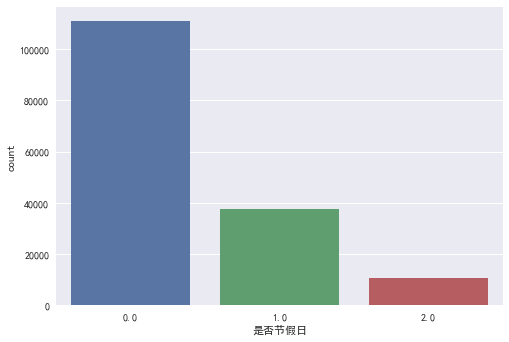

In [27]:
sns.countplot(data['是否节假日'])

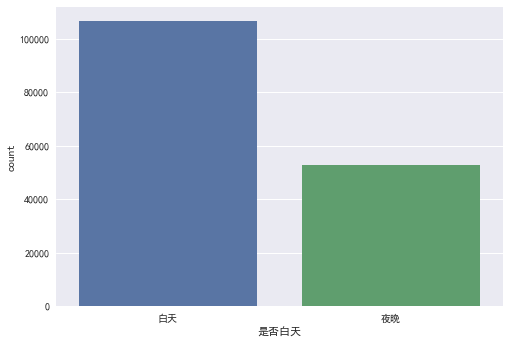

In [29]:
sns.countplot(data['是否白天'])

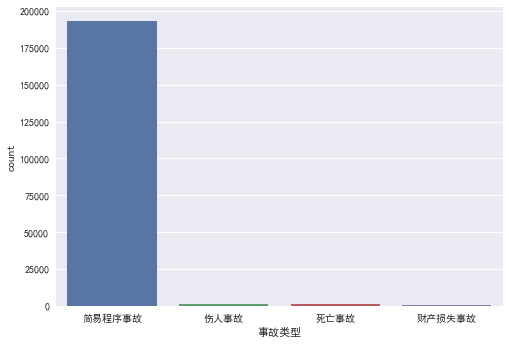

In [24]:
sns.countplot(data['事故类型'])

In [21]:
nan_columns = {}
length_data = len(data)
for i in range(len(data.columns)): 
    odds = sum(data[data.columns[i]].isnull())/length_data
    nan_columns[data.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+' : '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

中央隔离设施 : 0.967672095405  事故发生时间 : 0.0  事故地点 : 0.0  事故多发点段 : 0.0688483502376  
事故类型 : 0.0  交通信号方式（控制） : 0.962027702355  交通标志标线完善 : 0.0  公路行政等级 : 0.705798747841  
公里数 : 0.0903102887912  其他交通安全设施不全 : 0.0686292988828  单向路宽 : 0.992445275368  双向路宽 : 0.997300064697  
在道路横断面位置 : 0.962027702355  地形 : 0.96205826766  天气 : 0.0  所辖乡镇 : 5.60363930902e-05  
星期 : 0.0  是否运载危险物品 : 0.0  涉外事故 : 0.0  照明条件 : 0.962027702355  
能见度 : 0.962511653023  行政区划 : 0.0  路侧防护设施类型 : 0.96226713058  路口路段类型 : 0.962073550313  
路号 : 0.0903051945736  路表情况 : 0.962027702355  路面状况 : 0.962027702355  路面结构 : 0.962063361878  
路面附着系数 : 0.999327563283  道路安全属性 : 0.965196305673  道路安全隐患督办等级 : 0.97480399998  道路物理隔离 : 0.962068456095  
道路类型 : 0.0903306656614  道路线型 : 0.96205826766  长下坡路段 : 0.0  

# 2. 路面附着系数不为空

In [254]:
data_attach_notnull = data[data['路面附着系数'].notnull()]

In [255]:
len(data_attach_notnull)

132

## 2.1 整合路宽

In [256]:
data_way = data_attach_notnull[['单向路宽','双向路宽']]
data_way.columns=['oneWay','twoWay']

#填充空值为-1
data_way.fillna(-1,inplace=True)

def isTwowayRoad(row,oneWay,twoWay):
    if row[oneWay] == -1 and row[twoWay] == -1:
        return np.nan
    elif row[oneWay] == -1:
        return '是'
    elif  row[twoWay] == -1:
        return  '否'

def getRoadWidth(row,oneWay,twoWay):
    if row[oneWay] == -1:
        return row[twoWay]
    elif  row[twoWay] == -1:
        return  row[oneWay]

data_isTwoWay = pd.DataFrame(data_way.apply(isTwowayRoad, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['isTwoWay'])
data_roadWidth = pd.DataFrame(data_way.apply(getRoadWidth, axis=1, oneWay='oneWay', twoWay='twoWay'),\
                             columns=['roadWidth'])

data_attach_notnull.insert(value=data_isTwoWay,column='是否双道',loc=3)
data_attach_notnull.insert(value=data_roadWidth,column='路宽',loc=4)

# pd.DataFrame(data_attach_notnull[(data_attach_notnull['路宽']==-1)])[['是否双道','路宽','单向路宽','双向路宽']]
data_attach_notnull.drop(['单向路宽','双向路宽'],axis=1,inplace=True)
del data_way,data_isTwoWay,data_roadWidth

D:\ProgramFiles\Anaconda3\lib\site-packages\pandas\core\frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [257]:
nan_columns = {}
length_data = len(data_attach_notnull)
for i in range(len(data_attach_notnull.columns)): 
    odds = sum(data_attach_notnull[data_attach_notnull.columns[i]].isnull())/length_data
    nan_columns[data_attach_notnull.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+' : '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

中央隔离设施 : 0.0530303030303  是否节假日 : 0.19696969697  是否白天 : 0.19696969697  是否双道 : 0.0151515151515  
路宽 : 0.0  事故地点 : 0.0  事故多发点段 : 0.0  事故类型 : 0.0  
交通信号方式（控制） : 0.0  交通标志标线完善 : 0.0  公路行政等级 : 0.25  公里数 : 0.0  
其他交通安全设施不全 : 0.0  在道路横断面位置 : 0.0  地形 : 0.0  天气 : 0.0  
所辖乡镇 : 0.0  星期 : 0.0  是否运载危险物品 : 0.0  照明条件 : 0.0  
能见度 : 0.0  行政区划 : 0.0  路侧防护设施类型 : 0.0  路口路段类型 : 0.0  
路号 : 0.0  路表情况 : 0.0  路面状况 : 0.0  路面结构 : 0.0  
路面附着系数 : 0.0  道路安全属性 : 0.00757575757576  道路安全隐患督办等级 : 0.121212121212  道路物理隔离 : 0.0  
道路类型 : 0.0  道路线型 : 0.0  长下坡路段 : 0.0  

## 2.2 删除缺省值

In [258]:
data_attach_notnull = data_attach_notnull[~data_attach_notnull['中央隔离设施'].isnull()]
data_attach_notnull = data_attach_notnull[~data_attach_notnull['是否双道'].isnull()]
data_attach_notnull = data_attach_notnull[~data_attach_notnull['道路安全属性'].isnull()]
print(len(data_attach_notnull))

123


In [259]:
nan_columns = {}
length_data = len(data_attach_notnull)
for i in range(len(data_attach_notnull.columns)): 
    odds = sum(data_attach_notnull[data_attach_notnull.columns[i]].isnull())/length_data
    nan_columns[data_attach_notnull.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+' : '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

中央隔离设施 : 0.0  是否节假日 : 0.186991869919  是否白天 : 0.186991869919  是否双道 : 0.0  
路宽 : 0.0  事故地点 : 0.0  事故多发点段 : 0.0  事故类型 : 0.0  
交通信号方式（控制） : 0.0  交通标志标线完善 : 0.0  公路行政等级 : 0.260162601626  公里数 : 0.0  
其他交通安全设施不全 : 0.0  在道路横断面位置 : 0.0  地形 : 0.0  天气 : 0.0  
所辖乡镇 : 0.0  星期 : 0.0  是否运载危险物品 : 0.0  照明条件 : 0.0  
能见度 : 0.0  行政区划 : 0.0  路侧防护设施类型 : 0.0  路口路段类型 : 0.0  
路号 : 0.0  路表情况 : 0.0  路面状况 : 0.0  路面结构 : 0.0  
路面附着系数 : 0.0  道路安全属性 : 0.0  道路安全隐患督办等级 : 0.113821138211  道路物理隔离 : 0.0  
道路类型 : 0.0  道路线型 : 0.0  长下坡路段 : 0.0  

14


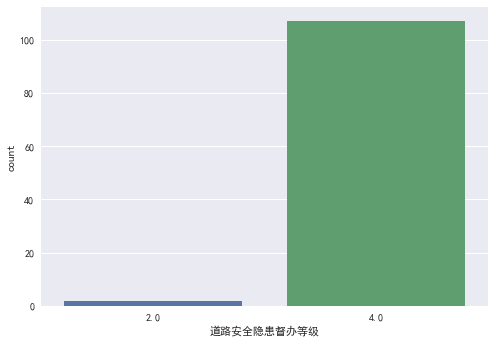

In [260]:
#道路安全隐患督办等级
sns.countplot(data_attach_notnull['道路安全隐患督办等级'])
print(sum(data_attach_notnull['道路安全隐患督办等级'].isnull()))
data_attach_notnull['道路安全隐患督办等级'].fillna(4.0,inplace=True)

32


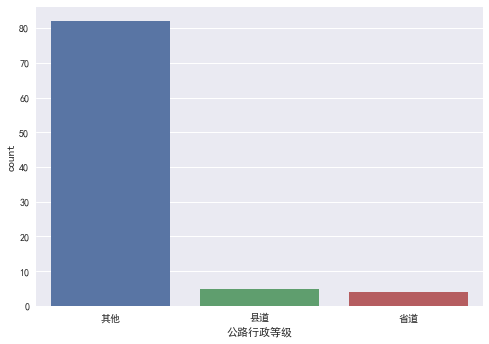

In [261]:
#公路行政等级 
sns.countplot(data_attach_notnull['公路行政等级'])
print(sum(data_attach_notnull['公路行政等级'].isnull()))

### 2.2.1 删除缺失行

In [262]:
data_attach_notnull_2 = data_attach_notnull[~data_attach_notnull['公路行政等级'].isnull()]
data_attach_notnull_2 = data_attach_notnull_2[~data_attach_notnull['是否节假日'].isnull()]
print(len(data_attach_notnull_2))

82


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


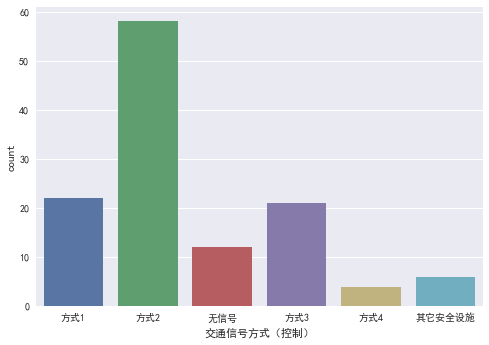

In [263]:
#设置  交通信号方式（控制）
sns.countplot(data_attach_notnull['交通信号方式（控制）'])
data_attach_notnull_2.loc[data_attach_notnull['交通信号方式（控制）']==345,'交通信号方式（控制）']='方式1'
data_attach_notnull_2.loc[data_attach_notnull['交通信号方式（控制）']==45,'交通信号方式（控制）']='方式2'
data_attach_notnull_2.loc[data_attach_notnull['交通信号方式（控制）']==456,'交通信号方式（控制）']='方式3'
data_attach_notnull_2.loc[data_attach_notnull['交通信号方式（控制）']==3456,'交通信号方式（控制）']='方式4'
sns.countplot(data_attach_notnull_2['交通信号方式（控制）'])

In [264]:
nan_columns = {}
length_data = len(data_attach_notnull_2)
for i in range(len(data_attach_notnull_2.columns)): 
    odds = sum(data_attach_notnull_2[data_attach_notnull_2.columns[i]].isnull())/length_data
    nan_columns[data_attach_notnull_2.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+' : '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

中央隔离设施 : 0.0  是否节假日 : 0.0  是否白天 : 0.0  是否双道 : 0.0  
路宽 : 0.0  事故地点 : 0.0  事故多发点段 : 0.0  事故类型 : 0.0  
交通信号方式（控制） : 0.0  交通标志标线完善 : 0.0  公路行政等级 : 0.0  公里数 : 0.0  
其他交通安全设施不全 : 0.0  在道路横断面位置 : 0.0  地形 : 0.0  天气 : 0.0  
所辖乡镇 : 0.0  星期 : 0.0  是否运载危险物品 : 0.0  照明条件 : 0.0  
能见度 : 0.0  行政区划 : 0.0  路侧防护设施类型 : 0.0  路口路段类型 : 0.0  
路号 : 0.0  路表情况 : 0.0  路面状况 : 0.0  路面结构 : 0.0  
路面附着系数 : 0.0  道路安全属性 : 0.0  道路安全隐患督办等级 : 0.0  道路物理隔离 : 0.0  
道路类型 : 0.0  道路线型 : 0.0  长下坡路段 : 0.0  

### 2.1.2 填充缺失数据

32


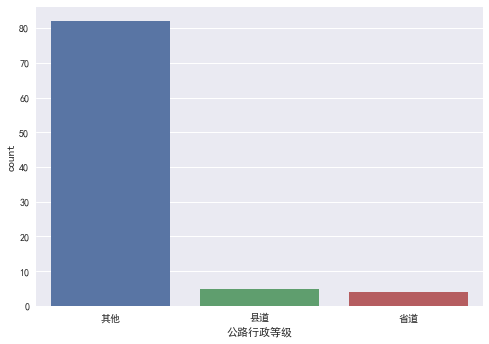

In [265]:
#公路行政等级 
sns.countplot(data_attach_notnull['公路行政等级'])
print(sum(data_attach_notnull['公路行政等级'].isnull()))
data_attach_notnull['公路行政等级'].fillna('其他',inplace=True)

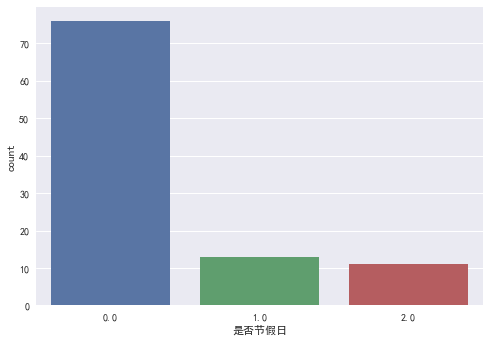

In [266]:
#是否节假日，
sns.countplot(data_attach_notnull['是否节假日'])
data_attach_notnull['是否节假日'].fillna(0,inplace=True)

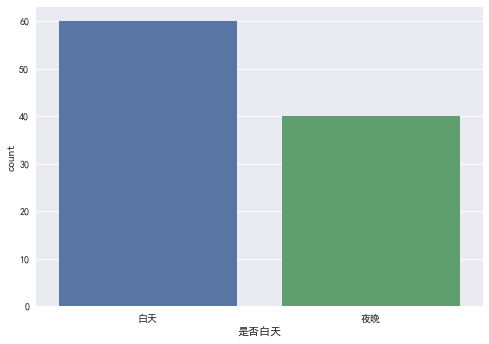

In [267]:
#是否白天
sns.countplot(data_attach_notnull['是否白天'])
data_attach_notnull['是否白天'].fillna('白天',inplace=True)

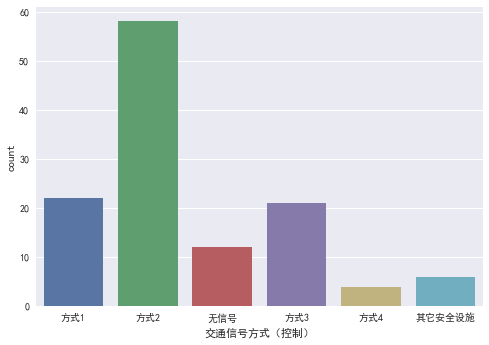

In [268]:
#设置 交通信号方式（控制）
sns.countplot(data_attach_notnull['交通信号方式（控制）'])
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==345,'交通信号方式（控制）']='方式1'
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==45,'交通信号方式（控制）']='方式2'
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==456,'交通信号方式（控制）']='方式3'
data_attach_notnull.loc[data_attach_notnull['交通信号方式（控制）']==3456,'交通信号方式（控制）']='方式4'
sns.countplot(data_attach_notnull['交通信号方式（控制）'])

In [269]:
nan_columns = {}
length_data = len(data_attach_notnull)
for i in range(len(data_attach_notnull.columns)): 
    odds = sum(data_attach_notnull[data_attach_notnull.columns[i]].isnull())/length_data
    nan_columns[data_attach_notnull.columns[i]] = odds

j = 0
for i in nan_columns:
    print(i+' : '+str(nan_columns[i]),end='  ')
    j+=1
    if j==4:
        j=0
        print()

中央隔离设施 : 0.0  是否节假日 : 0.0  是否白天 : 0.0  是否双道 : 0.0  
路宽 : 0.0  事故地点 : 0.0  事故多发点段 : 0.0  事故类型 : 0.0  
交通信号方式（控制） : 0.0  交通标志标线完善 : 0.0  公路行政等级 : 0.0  公里数 : 0.0  
其他交通安全设施不全 : 0.0  在道路横断面位置 : 0.0  地形 : 0.0  天气 : 0.0  
所辖乡镇 : 0.0  星期 : 0.0  是否运载危险物品 : 0.0  照明条件 : 0.0  
能见度 : 0.0  行政区划 : 0.0  路侧防护设施类型 : 0.0  路口路段类型 : 0.0  
路号 : 0.0  路表情况 : 0.0  路面状况 : 0.0  路面结构 : 0.0  
路面附着系数 : 0.0  道路安全属性 : 0.0  道路安全隐患督办等级 : 0.0  道路物理隔离 : 0.0  
道路类型 : 0.0  道路线型 : 0.0  长下坡路段 : 0.0  

## 2.3 预测

In [270]:
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

## 2.3.1 预测data_attach_notnull

In [271]:
#生成训练集和测试集
data_attach_notnull['index'] = range(len(data_attach_notnull))
data_attach_notnull_test = data_attach_notnull.sample(frac=0.2,replace=False)
#获取训练集
index = ~data_attach_notnull.index.isin(data_attach_notnull_test['index'])
data_attach_notnull_train = data_attach_notnull[index]


#转换为数字
data_attach_notnull.drop(['index'],axis=1,inplace=True)
data_attach_notnull_train.drop(['index'],axis=1,inplace=True)
data_attach_notnull_test.drop(['index'],axis=1,inplace=True)
columnsToNum = list(data_attach_notnull_train.columns)

set_toNum = pd.DataFrame()
for i in columnsToNum:
    set_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull[i])


trainSet_toNum = pd.DataFrame()
for i in columnsToNum:
    trainSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_train[i])

# columnsToNum = list(data_attach_notnull_test.columns)
testSet_toNum = pd.DataFrame()
for i in columnsToNum:
    testSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_test[i])

del data_attach_notnull_train,data_attach_notnull_test

#统一训练集、测试集格式
train_features = trainSet_toNum.drop(['事故类型'],axis=1).columns

x_all =np.array(set_toNum.drop(['事故类型'],axis=1)) 
y_all = np.array(set_toNum['事故类型'])
y = np.zeros((len(y_all),len(set_toNum.groupby('事故类型')) ))
for i in range(len(y_all)):
    y[i][y_all[i]] = 1
y_all = np.mat(y)
x_all = np.mat(x_all)
# y_all = np.mat(y_all)

x_train =np.array(trainSet_toNum.drop(['事故类型'],axis=1)) 
y_train = np.array(trainSet_toNum['事故类型'])
y = np.zeros((len(y_train),len(trainSet_toNum.groupby('事故类型')) ))
for i in range(len(y_train)):
    y[i][y_train[i]] = 1
y_train = np.mat(y)
x_train = np.mat(x_train)
# y_train = np.mat(y_train)


x_test =np.array(testSet_toNum.drop(['事故类型'],axis=1)) 
y_test = np.array(testSet_toNum['事故类型'])
y = np.zeros((len(y_test),len(testSet_toNum.groupby('事故类型')) ))
for i in range(len(y_test)):
    y[i][y_test[i]] = 1
y_test = np.mat(y)
x_test = np.mat(x_test)
# y_test = np.mat(y_test)


del y,trainSet_toNum,testSet_toNum

In [272]:
#测试oob_score_
rf1 = RandomForestClassifier(n_estimators= 50,max_features=5 ,min_samples_split=2,\
                             min_samples_leaf=1,\
                             oob_score=True, random_state=10)
rf1.fit(x_all,y_all)
print (rf1.oob_score_)

0.859078590786


In [273]:
corr_pre_test = np.equal(np.argmax(rf1.predict(x_all),axis=1),\
                    np.argmax(y_all,axis=1,).reshape( (1,len(np.argmax(y_all,axis=1,))) )\
                   )
acc_test = np.mean(corr_pre_test)

print('测试集准确率：%s'%acc_test)

测试集准确率：1.0


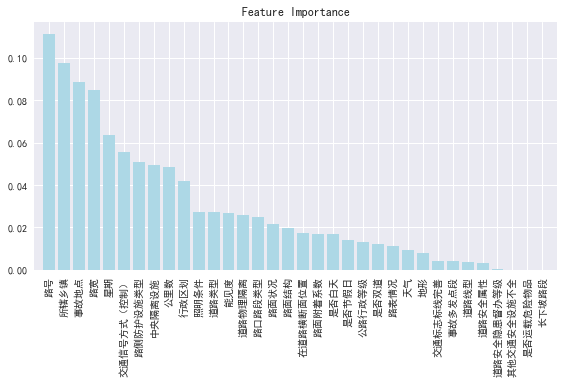

In [274]:
importances = rf1.feature_importances_
indice = np.argsort(importances)[::-1]#按照索引对应值的大小对索引排序

plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]),
       importances[indice],
       color='lightblue',
       align='center')
plt.xticks(range(x_train.shape[1]),
          train_features[indice],
           rotation=90)
plt.xlim([-1,x_train.shape[1]])
plt.tight_layout()
plt.show()

## 2.3.2 预测data_attach_notnull_2

In [275]:
#生成训练集和测试集


data_attach_notnull_2['index'] = range(len(data_attach_notnull_2))
data_attach_notnull_test = data_attach_notnull_2.sample(frac=0.2,replace=False)
#获取训练集
index = ~data_attach_notnull_2.index.isin(data_attach_notnull_test['index'])
data_attach_notnull_train = data_attach_notnull_2[index]


#转换为数字
data_attach_notnull_2.drop(['index'],axis=1,inplace=True)
data_attach_notnull_train.drop(['index'],axis=1,inplace=True)
data_attach_notnull_test.drop(['index'],axis=1,inplace=True)
columnsToNum = list(data_attach_notnull_train.columns)

set_toNum = pd.DataFrame()
for i in columnsToNum:
    set_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_2[i])


trainSet_toNum = pd.DataFrame()
for i in columnsToNum:
    trainSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_train[i])

# columnsToNum = list(data_attach_notnull_test.columns)
testSet_toNum = pd.DataFrame()
for i in columnsToNum:
    testSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_test[i])

del data_attach_notnull_train,data_attach_notnull_test

#统一训练集、测试集格式
train_features = trainSet_toNum.drop(['事故类型'],axis=1).columns

x_all =np.array(set_toNum.drop(['事故类型'],axis=1)) 
y_all = np.array(set_toNum['事故类型'])
y = np.zeros((len(y_all),len(set_toNum.groupby('事故类型')) ))
for i in range(len(y_all)):
    y[i][y_all[i]] = 1
y_all = np.mat(y)
x_all = np.mat(x_all)
# y_all = np.mat(y_all)

x_train =np.array(trainSet_toNum.drop(['事故类型'],axis=1)) 
y_train = np.array(trainSet_toNum['事故类型'])
y = np.zeros((len(y_train),len(trainSet_toNum.groupby('事故类型')) ))
for i in range(len(y_train)):
    y[i][y_train[i]] = 1
y_train = np.mat(y)
x_train = np.mat(x_train)
# y_train = np.mat(y_train)


x_test =np.array(testSet_toNum.drop(['事故类型'],axis=1)) 
y_test = np.array(testSet_toNum['事故类型'])
y = np.zeros((len(y_test),len(testSet_toNum.groupby('事故类型')) ))
for i in range(len(y_test)):
    y[i][y_test[i]] = 1
y_test = np.mat(y)
x_test = np.mat(x_test)
# y_test = np.mat(y_test)


del y,trainSet_toNum,testSet_toNum

In [276]:
#测试oob_score_
rf2 = RandomForestClassifier(n_estimators= 53,max_features=4,min_samples_split=2,\
                             min_samples_leaf=1,\
                             oob_score=True, random_state=10)
rf2.fit(x_all,y_all)
print (rf2.oob_score_)

0.878048780488


In [277]:
corr_pre_test = np.equal(np.argmax(rf2.predict(x_test),axis=1),\
                    np.argmax(y_test,axis=1,).reshape( (1,len(np.argmax(y_test,axis=1,))) )\
                   )
acc_test = np.mean(corr_pre_test)
print('测试集准确率：%s'%acc_test)

测试集准确率：0.5


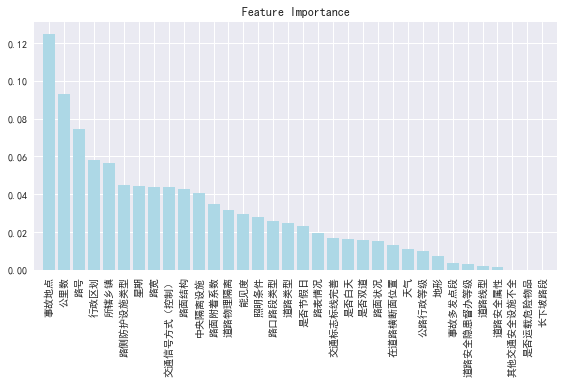

In [278]:
importances = rf2.feature_importances_
indice = np.argsort(importances)[::-1]#按照索引对应值的大小对索引排序

plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]),
       importances[indice],
       color='lightblue',
       align='center')
plt.xticks(range(x_train.shape[1]),
          train_features[indice],
           rotation=90)
plt.xlim([-1,x_train.shape[1]])
plt.tight_layout()
plt.show()

In [300]:
data_attach_notnull_2.drop(['路号','所辖乡镇','事故地点','星期'],axis=1,inplace=True)
data_attach_notnull_2.drop(['公里数'],axis=1,inplace=True)

In [301]:
#生成训练集和测试集


data_attach_notnull_2['index'] = range(len(data_attach_notnull_2))
data_attach_notnull_test = data_attach_notnull_2.sample(frac=0.2,replace=False)
#获取训练集
index = ~data_attach_notnull_2.index.isin(data_attach_notnull_test['index'])
data_attach_notnull_train = data_attach_notnull_2[index]


#转换为数字
data_attach_notnull_2.drop(['index'],axis=1,inplace=True)
data_attach_notnull_train.drop(['index'],axis=1,inplace=True)
data_attach_notnull_test.drop(['index'],axis=1,inplace=True)
columnsToNum = list(data_attach_notnull_train.columns)

set_toNum = pd.DataFrame()
for i in columnsToNum:
    set_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_2[i])


trainSet_toNum = pd.DataFrame()
for i in columnsToNum:
    trainSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_train[i])

# columnsToNum = list(data_attach_notnull_test.columns)
testSet_toNum = pd.DataFrame()
for i in columnsToNum:
    testSet_toNum[i] = preprocessing.LabelEncoder().fit_transform(data_attach_notnull_test[i])

del data_attach_notnull_train,data_attach_notnull_test

#统一训练集、测试集格式
train_features = trainSet_toNum.drop(['事故类型'],axis=1).columns

x_all =np.array(set_toNum.drop(['事故类型'],axis=1)) 
y_all = np.array(set_toNum['事故类型'])
y = np.zeros((len(y_all),len(set_toNum.groupby('事故类型')) ))
for i in range(len(y_all)):
    y[i][y_all[i]] = 1
y_all = np.mat(y)
x_all = np.mat(x_all)
# y_all = np.mat(y_all)

x_train =np.array(trainSet_toNum.drop(['事故类型'],axis=1)) 
y_train = np.array(trainSet_toNum['事故类型'])
y = np.zeros((len(y_train),len(trainSet_toNum.groupby('事故类型')) ))
for i in range(len(y_train)):
    y[i][y_train[i]] = 1
y_train = np.mat(y)
x_train = np.mat(x_train)
# y_train = np.mat(y_train)


x_test =np.array(testSet_toNum.drop(['事故类型'],axis=1)) 
y_test = np.array(testSet_toNum['事故类型'])
y = np.zeros((len(y_test),len(testSet_toNum.groupby('事故类型')) ))
for i in range(len(y_test)):
    y[i][y_test[i]] = 1
y_test = np.mat(y)
x_test = np.mat(x_test)
# y_test = np.mat(y_test)


del y,trainSet_toNum,testSet_toNum

In [327]:
#测试oob_score_
rf3 = RandomForestClassifier(n_estimators= 105,max_features=0.35,min_samples_split=2,\
                             min_samples_leaf=1,\
                             oob_score=True, random_state=10)
rf3.fit(x_all,y_all)
print (rf3.oob_score_)

0.861788617886


In [283]:
corr_pre_test = np.equal(np.argmax(rf3.predict(x_all),axis=1),\
                    np.argmax(y_all,axis=1,).reshape( (1,len(np.argmax(y_all,axis=1,))) )\
                   )
acc_test = np.mean(corr_pre_test)
print('测试集准确率：%s'%acc_test)

测试集准确率：1.0


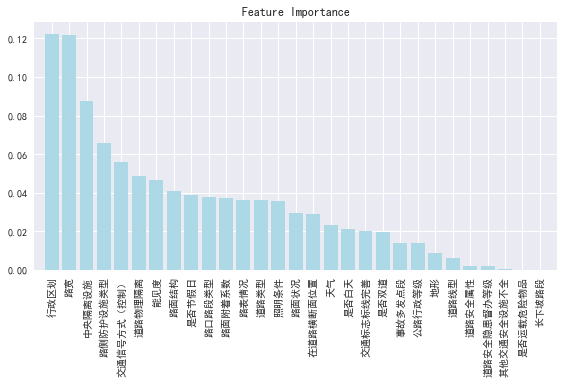

In [328]:
importances = rf3.feature_importances_
indice = np.argsort(importances)[::-1]#按照索引对应值的大小对索引排序

plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]),
       importances[indice],
       color='lightblue',
       align='center')
plt.xticks(range(x_train.shape[1]),
          train_features[indice],
           rotation=90)
plt.xlim([-1,x_train.shape[1]])
plt.tight_layout()
plt.show()

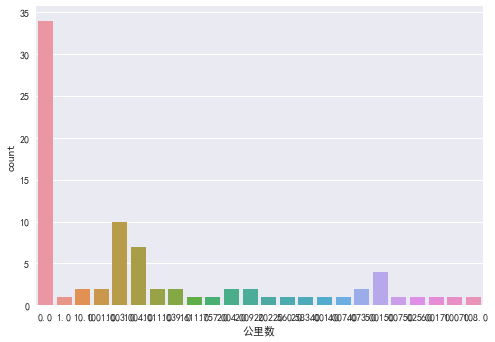

In [297]:
sns.countplot(data_attach_notnull_2['公里数'])